In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn import metrics
import pandas_datareader.data as web
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [3]:
#Read stock data use pandas_datareader.data from web
# Get Stock Data
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

In [4]:
# Select columns
base = stk_data.loc[:, ('Adj Close', 'MSFT')]
X1 = stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]
X2 = ccy_data
X3 = idx_data
print(X1)
print(X2)
print(X3)

Attributes   Adj Close            
Symbols          GOOGL         IBM
Date                              
2017-09-22   47.162998  109.384422
2017-09-25   46.714001  109.942169
2017-09-26   46.871498  110.462242
2017-09-27   47.994999  109.783882
2017-09-28   48.240501  109.783882
...                ...         ...
2022-09-15  102.910004  125.489998
2022-09-16  102.800003  127.269997
2022-09-19  103.070000  127.730003
2022-09-20  101.139999  126.300003
2022-09-21   99.279999  124.930000

[1258 rows x 2 columns]
            DEXJPUS  DEXUSUK
DATE                        
2017-09-25   111.64   1.3457
2017-09-26   112.16   1.3422
2017-09-27   112.76   1.3401
2017-09-28   112.66   1.3435
2017-09-29   112.64   1.3402
...             ...      ...
2022-09-12   142.41   1.1701
2022-09-13   144.30   1.1526
2022-09-14   142.93   1.1564
2022-09-15   143.57   1.1472
2022-09-16   143.04   1.1419

[1300 rows x 2 columns]
              SP500      DJIA  VIXCLS
DATE                                 
2017-09

In [5]:
#Standardized data (X1, X2, X3) with kept index (date)
standard_scaler = preprocessing.StandardScaler()
sX1 = standard_scaler.fit_transform(X1.values)
sX2 = standard_scaler.fit_transform(X2.values)
sX3 = standard_scaler.fit_transform(X3.values)
print(type(sX1))
sX1

<class 'numpy.ndarray'>


array([[-1.14363814, -0.56075635],
       [-1.15785347, -0.5092785 ],
       [-1.15286708, -0.46127781],
       ...,
       [ 0.62638652,  1.13246876],
       [ 0.5652824 ,  1.00048535],
       [ 0.50639448,  0.87403947]])

In [6]:
sX1 = pd.DataFrame(index = X1.index,data = sX1,columns=X1.columns)
sX2 = pd.DataFrame(index = X2.index,data = sX2,columns=X2.columns)
sX3 = pd.DataFrame(index = X3.index,data = sX3,columns=X3.columns)
sX1

Attributes Adj Close          
Symbols        GOOGL       IBM
Date                          
2017-09-22 -1.143638 -0.560756
2017-09-25 -1.157853 -0.509278
2017-09-26 -1.152867 -0.461278
2017-09-27 -1.117297 -0.523888
2017-09-28 -1.109524 -0.523888
...              ...       ...
2022-09-15  0.621321  0.925725
2022-09-16  0.617838  1.090012
2022-09-19  0.626387  1.132469
2022-09-20  0.565282  1.000485
2022-09-21  0.506394  0.874039

[1258 rows x 2 columns]

In [7]:
X1['Adj Close']

Symbols,GOOGL,IBM
Date,,
2017-09-22,47.162998,109.384422
2017-09-25,46.714001,109.942169
2017-09-26,46.871498,110.462242
2017-09-27,47.994999,109.783882
2017-09-28,48.240501,109.783882
...,...,...
2022-09-15,102.910004,125.489998
2022-09-16,102.800003,127.269997
2022-09-19,103.070000,127.730003


In [8]:
# Calculate ความแตกต่างของค่า ราคา 'Adj Close', 'MSFT’)ย้อนหลัง return_period วัน
return_period = 1 #predict 1 วันข้างหน้า
Y = base.shift(-return_period)
X4_3DT = base.diff(3*return_period).shift(-3*return_period)
X4_6DT = base.diff(6*return_period).shift(-6*return_period)
X4_12DT = base.diff(12*return_period).shift(-12*return_period)
X4 = pd.concat([X4_3DT, X4_6DT, X4_12DT], axis=1)
X4.columns = ['MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X4 = pd.DataFrame(standard_scaler.fit_transform(X4.values), index = X4.index,columns=X4.columns)

# Forming Dataset
X = pd.concat([sX1, sX2, sX3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1)
print(type(dataset))


<class 'pandas.core.frame.DataFrame'>


In [9]:
dataset.dropna(inplace=True)
dataset

,"(Adj Close, MSFT)","(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-09-25,68.838745,-1.157853,-0.509278,-0.028635,0.589904,-1.286788,-1.525064,-1.184813,0.028036,0.012589,0.113076
2017-09-26,69.393127,-1.152867,-0.461278,0.039003,0.530386,-1.286526,-1.527919,-1.189420,0.130014,0.063704,0.174069
2017-09-27,69.411919,-1.117297,-0.523888,0.117046,0.494676,-1.271704,-1.514242,-1.223973,0.052712,0.145731,0.154901
2017-09-28,69.994507,-1.109524,-0.523888,0.104039,0.552493,-1.267315,-1.504422,-1.260830,-0.008144,0.146921,0.167101
2017-09-29,70.107269,-1.095420,-0.564232,0.101437,0.496376,-1.253801,-1.498628,-1.265437,-0.039399,0.107691,0.107850
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-29,262.970001,0.827428,1.370592,3.496319,-2.367281,0.942316,0.852475,0.658019,-0.917755,-1.009589,-2.002878
2022-08-30,261.470001,0.812232,1.303216,3.495018,-2.481215,0.877722,0.777745,0.658019,-1.281842,-0.669271,-1.852660
2022-08-31,260.399994,0.789436,1.198921,3.489815,-2.488018,0.832441,0.709729,0.618859,-1.511148,0.271982,-1.733970
2022-09-01,256.059998,0.837560,1.310600,3.651104,-2.668271,0.849661,0.745136,0.583154,-0.476643,0.684414,-1.826696


In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1228 entries, 2017-09-25 to 2022-09-02
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Adj Close, MSFT)   1228 non-null   float64
 1   (Adj Close, GOOGL)  1228 non-null   float64
 2   (Adj Close, IBM)    1228 non-null   float64
 3   DEXJPUS             1228 non-null   float64
 4   DEXUSUK             1228 non-null   float64
 5   SP500               1228 non-null   float64
 6   DJIA                1228 non-null   float64
 7   VIXCLS              1228 non-null   float64
 8   MSFT_3DT            1228 non-null   float64
 9   MSFT_6DT            1228 non-null   float64
 10  MSFT_12DT           1228 non-null   float64
dtypes: float64(11)
memory usage: 115.1 KB


In [11]:
Y = pd.DataFrame(dataset[dataset.columns[0]].reset_index(drop=True))
X = pd.DataFrame(dataset[dataset.columns[1:]].reset_index(drop=True))
print(Y)
print(X)

       Adj Close
            MSFT
0      68.838745
1      69.393127
2      69.411919
3      69.994507
4      70.107269
...          ...
1223  262.970001
1224  261.470001
1225  260.399994
1226  256.059998
1227  253.250000

[1228 rows x 1 columns]
      (Adj Close, GOOGL)  (Adj Close, IBM)   DEXJPUS   DEXUSUK     SP500  \
0              -1.157853         -0.509278 -0.028635  0.589904 -1.286788   
1              -1.152867         -0.461278  0.039003  0.530386 -1.286526   
2              -1.117297         -0.523888  0.117046  0.494676 -1.271704   
3              -1.109524         -0.523888  0.104039  0.552493 -1.267315   
4              -1.095420         -0.564232  0.101437  0.496376 -1.253801   
...                  ...               ...       ...       ...       ...   
1223            0.827428          1.370592  3.496319 -2.367281  0.942316   
1224            0.812232          1.303216  3.495018 -2.481215  0.877722   
1225            0.789436          1.198921  3.489815 -2.488018  0.8324

In [12]:
X.corr()

,"(Adj Close, GOOGL)","(Adj Close, IBM)",DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
"(Adj Close, GOOGL)",1.000000,0.602288,0.394167,0.260117,0.985392,0.960211,0.149650,-0.056689,-0.077309,-0.107068
"(Adj Close, IBM)",0.602288,1.000000,0.571359,0.216697,0.609598,0.661757,-0.285991,-0.088046,-0.133327,-0.180314
DEXJPUS,0.394167,0.571359,1.000000,-0.385863,0.353092,0.345981,0.057115,-0.082923,-0.112704,-0.179762
DEXUSUK,0.260117,0.216697,-0.385863,1.000000,0.272324,0.318102,-0.326957,0.011714,0.014592,0.041908
SP500,0.985392,0.609598,0.353092,0.272324,1.000000,0.986202,0.104244,-0.063747,-0.089512,-0.125886
DJIA,0.960211,0.661757,0.345981,0.318102,0.986202,1.000000,-0.011208,-0.066438,-0.093749,-0.128566
VIXCLS,0.149650,-0.285991,0.057115,-0.326957,0.104244,-0.011208,1.000000,0.057066,0.080773,0.105670
MSFT_3DT,-0.056689,-0.088046,-0.082923,0.011714,-0.063747,-0.066438,0.057066,1.000000,0.687195,0.491948
MSFT_6DT,-0.077309,-0.133327,-0.112704,0.014592,-0.089512,-0.093749,0.080773,0.687195,1.000000,0.677054
MSFT_12DT,-0.107068,-0.180314,-0.179762,0.041908,-0.125886,-0.128566,0.105670,0.491948,0.677054,1.000000


In [13]:
lower = pd.DataFrame(np.tril(X.corr(),-1),columns = X.columns)
to_drop = [column for column in lower.columns if any(lower[column] > 0.9)]
to_drop


[('Adj Close', 'GOOGL'), 'SP500']

In [14]:
X.drop(columns=to_drop,inplace=True)


In [15]:
X

,"(Adj Close, IBM)",DEXJPUS,DEXUSUK,DJIA,VIXCLS,MSFT_3DT,MSFT_6DT,MSFT_12DT
0,-0.509278,-0.028635,0.589904,-1.525064,-1.184813,0.028036,0.012589,0.113076
1,-0.461278,0.039003,0.530386,-1.527919,-1.189420,0.130014,0.063704,0.174069
2,-0.523888,0.117046,0.494676,-1.514242,-1.223973,0.052712,0.145731,0.154901
3,-0.523888,0.104039,0.552493,-1.504422,-1.260830,-0.008144,0.146921,0.167101
4,-0.564232,0.101437,0.496376,-1.498628,-1.265437,-0.039399,0.107691,0.107850
...,...,...,...,...,...,...,...,...
1223,1.370592,3.496319,-2.367281,0.852475,0.658019,-0.917755,-1.009589,-2.002878
1224,1.303216,3.495018,-2.481215,0.777745,0.658019,-1.281842,-0.669271,-1.852660
1225,1.198921,3.489815,-2.488018,0.709729,0.618859,-1.511148,0.271982,-1.733970
1226,1.310600,3.651104,-2.668271,0.745136,0.583154,-0.476643,0.684414,-1.826696


In [16]:
#shuffle spilt
# Rseed = 55
# x_train_set , x_test, y_train_set , y_test = train_test_split(X,Y,test_size= 0.3,random_state= Rseed)
# x_train,x_validate,y_train,y_validate = train_test_split(x_train_set,y_train_set,test_size=0.3 ,random_state= Rseed)
from math import ceil, floor
#test_size =  ceil(0.3 * len( X ))
train_size = floor(0.7 * len( X ))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]


In [17]:
# Cross Validation Model
# set k-fold crossvalidation with shuffle
num_fold = 50
seed = 500
kfold = KFold(n_splits=num_fold, shuffle = True, random_state=seed)

In [18]:
import warnings
warnings.filterwarnings('ignore')
# Model selection
model_LM = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
#c_val ลองอย่างน้อย 3 ค่า [0.1, 1, 10, 100]
lst = [0.1, 1, 10, 100]
c_val = 0
AVG_Linear_Model =[]
AVG_SVR_linear =[]
AVG_SVR_rbf = []
AVG_SVC_poly = []
for i in lst:
    c_val = i
    svr_lin = SVR(kernel='linear', C=c_val)
    svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.01)
    svr_poly = SVR(kernel='poly', C=c_val, degree=2)
    #Calculate accuracy score for each model
    score_LM    =  cross_val_score(model_LM, X_train, Y_train, cv=kfold)
    score_lin   =  cross_val_score(svr_lin, X_train, Y_train, cv=kfold)
    score_rbf   =  cross_val_score(svr_rbf, X_train, Y_train, cv=kfold)
    score_poly  =  cross_val_score(svr_poly, X_train, Y_train, cv=kfold)
    # View score k-fold
    # Valication score comparison
    score = pd.DataFrame({'Linear Model':score_LM,'SVR_linear':score_lin, 'SVR_rbf': score_rbf, 'SVR_poly':
    score_poly})
    score_mean = pd.DataFrame({'AVG Linear Model':[score_LM.mean()],'AVG SVR_linear':[score_lin.mean()],
    'AVG SVR_rbf': [score_rbf.mean()], 'AVG SVC_poly': [score_poly.mean()]})
    print(score)
    print(score_mean)
    #display( plot ( score ))
    AVG_Linear_Model.append(score_LM.mean())
    AVG_SVR_linear.append(score_lin.mean())
    AVG_SVR_rbf.append(score_rbf.mean())
    AVG_SVC_poly.append(score_poly.mean())


    Linear Model  SVR_linear   SVR_rbf  SVR_poly
0       0.938447    0.723164  0.024827  0.179762
1       0.901703    0.692824  0.027937  0.113107
2       0.834725    0.408511 -0.160501 -0.061049
3       0.872303    0.643952  0.020821  0.196300
4       0.908473    0.574065 -0.022260  0.014428
5       0.921702    0.636858  0.000480  0.190107
6       0.854871    0.660929 -0.040587  0.066422
7       0.858152    0.654564  0.031544  0.126707
8       0.882063    0.733364  0.034619  0.131761
9       0.881650    0.555906 -0.035856  0.063926
10      0.728541    0.743685 -0.210803  0.049645
11      0.893768    0.656235  0.031500  0.095290
12      0.860566    0.654331  0.021197  0.168858
13      0.824900    0.497425  0.016277  0.119588
14      0.795973    0.744678 -0.121304  0.061360
15      0.938673    0.629806 -0.025372  0.034021
16      0.839391    0.564494 -0.047513  0.093417
17      0.865345    0.435102 -0.272634 -0.103185
18      0.942301    0.566685 -0.202332 -0.138406
19      0.903637    

In [19]:
print(score_LM)
print(score_lin)
print(score_rbf)
print(score_poly)

[0.93844712 0.90170262 0.83472497 0.87230292 0.9084728  0.92170203
 0.8548709  0.85815173 0.8820634  0.88164952 0.72854069 0.89376784
 0.86056598 0.82489961 0.79597304 0.93867268 0.83939069 0.8653452
 0.94230054 0.90363671 0.87813299 0.8345213  0.79754938 0.85125032
 0.87845005 0.81282654 0.9009692  0.76608117 0.74016166 0.93178662
 0.82614024 0.81845213 0.9267494  0.92948353 0.90454496 0.91336419
 0.87442694 0.97160466 0.92111586 0.95827422 0.77085252 0.78666374
 0.87581138 0.93294201 0.87221502 0.87550538 0.89499466 0.88477693
 0.78277585 0.93298802]
[0.92664748 0.86955552 0.81714058 0.83914011 0.90050204 0.93372404
 0.85246652 0.85884883 0.8991075  0.85282481 0.69404403 0.90201888
 0.84582436 0.80768137 0.8755681  0.9564415  0.81911476 0.83566701
 0.92825376 0.90707906 0.87613501 0.84635285 0.7817983  0.82142714
 0.88927489 0.79160938 0.87606861 0.70903398 0.73657021 0.90759728
 0.83833498 0.78265486 0.92728609 0.92254481 0.90172051 0.90371834
 0.88177755 0.97376961 0.9051271  0.953

In [20]:
# View score k-fold
# Valication score comparison
score = pd.DataFrame({'Linear Model':score_LM,'SVR_linear':score_lin, 'SVR_rbf': score_rbf, 'SVR_poly':
score_poly})
score_mean = pd.DataFrame({'AVG Linear Model':[score_LM.mean()],'AVG SVR_linear':[score_lin.mean()],
'AVG SVR_rbf': [score_rbf.mean()], 'AVG SVC_poly': [score_poly.mean()]})
print(score)
print(score_mean)
#display( plot ( score ))

    Linear Model  SVR_linear   SVR_rbf  SVR_poly
0       0.938447    0.926647  0.938545  0.879772
1       0.901703    0.869556  0.902759  0.893566
2       0.834725    0.817141  0.846347  0.874123
3       0.872303    0.839140  0.857384  0.828009
4       0.908473    0.900502  0.932414  0.820462
5       0.921702    0.933724  0.970231  0.747879
6       0.854871    0.852467  0.925488  0.902081
7       0.858152    0.858849  0.904252  0.907751
8       0.882063    0.899108  0.945647  0.817341
9       0.881650    0.852825  0.898057  0.908795
10      0.728541    0.694044  0.872537  0.860028
11      0.893768    0.902019  0.949998  0.899688
12      0.860566    0.845824  0.904017  0.867758
13      0.824900    0.807681  0.916526  0.785113
14      0.795973    0.875568  0.939353  0.806265
15      0.938673    0.956441  0.971103  0.874965
16      0.839391    0.819115  0.909792  0.813770
17      0.865345    0.835667  0.878038  0.863027
18      0.942301    0.928254  0.957129  0.897754
19      0.903637    

In [21]:
# Predict all models ( LM, SVR_linear, SVR_rbf, SVR Poly )
LM_pred = model_LM.fit(X_train, Y_train).predict(X_test)
# Model prediction performance evaluation for all model ( LM, SVR_linear, SVR_rbf, SVR Poly )
#MSE 
LM_MSE = metrics.mean_squared_error(Y_test, LM_pred)
#R2
LM_r2 = metrics.r2_score(Y_test, LM_pred)
print(LM_MSE)
print(LM_r2)

4715.45770899116
-5.277103825394482


369
     (Adj Close, IBM)   DEXJPUS   DEXUSUK      DJIA    VIXCLS  MSFT_3DT  \
0           -0.130909 -0.370724  1.329626  1.028788 -0.081417 -1.344532   
1           -0.066067 -0.343409  1.322824  1.074728 -0.145916 -0.253790   
2            0.018473 -0.375927  1.407849  1.037604  0.124749  1.113515   
3           -0.076736 -0.391536  1.295616  0.980771  0.052188  0.811012   
4            0.058691 -0.414949  1.268407  1.005807 -0.186228 -0.703227   
..                ...       ...       ...       ...       ...       ...   
364          1.370592  3.496319 -2.367281  0.852475  0.658019 -0.917755   
365          1.303216  3.495018 -2.481215  0.777745  0.658019 -1.281842   
366          1.198921  3.489815 -2.488018  0.709729  0.618859 -1.511148   
367          1.310600  3.651104 -2.668271  0.745136  0.583154 -0.476643   
368          1.138006  3.664112 -2.598551  0.663165  0.572788  0.358310   

     MSFT_6DT  MSFT_12DT  
0   -0.387390   0.262627  
1   -0.693473   0.939326  
2    0.613328 

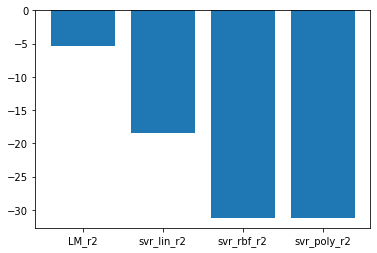

In [22]:
c_val = 0.1
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=0.01)
svr_poly = SVR(kernel='poly', C=c_val, degree=2)
LM_pred = model_LM.fit(X_train, Y_train).predict(X_test)
svr_lin_pred = svr_lin.fit(X_train,Y_train).predict(X_test)
svr_rbf_pred = svr_rbf.fit(X_train,Y_train).predict(X_test)
svr_poly_pred = svr_rbf.fit(X_train,Y_train).predict(X_test)
X_test.reset_index(inplace = True)
X_test.drop(columns = [X_test.columns[0]],inplace = True)
print(len(LM_pred))
print(X_test)
# plt.scatter(X_test["DEXJPUS"],LM_pred, c='magenta')
# plt.show()
LM_MSE = metrics.mean_squared_error(Y_test, LM_pred)
LM_r2 = metrics.r2_score(Y_test, LM_pred)
print (LM_MSE)
print(LM_r2)

svr_lin_MSE = metrics.mean_squared_error(Y_test, svr_lin_pred)
svr_lin_r2 = metrics.r2_score(Y_test, svr_lin_pred)
print (svr_lin_MSE)
print(svr_lin_r2)


svr_rbf_MSE = metrics.mean_squared_error(Y_test, svr_rbf_pred)
svr_rbf_r2 = metrics.r2_score(Y_test, svr_rbf_pred)
print (svr_rbf_MSE)
print(svr_rbf_r2)

svr_poly_MSE = metrics.mean_squared_error(Y_test, svr_poly_pred)
svr_poly_r2 = metrics.r2_score(Y_test, svr_poly_pred)
print (svr_poly_MSE)
print(svr_poly_r2)

# plt.bar(["LM_MSE","svr_lin_MSE","svr_rbf_MSE","svr_poly_MSE"],[LM_MSE,svr_lin_MSE,svr_rbf_MSE,svr_poly_MSE])
plt.bar(["LM_r2","svr_lin_r2","svr_rbf_r2","svr_poly_r2"],[LM_r2,svr_lin_r2,svr_rbf_r2,svr_poly_r2])
plt.show()